Template to train the Autoencoder / Encoder

In [1]:
import sys
import yaml
import phate
import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import scipy


sys.path.append("../")
from src.models.lit_encoder import LitDistEncoder
from src.data.make_dataset import train_dataloader

/home/mila/g/guillaume.huguet/.conda/envs/phate_fim/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Data Parameters
dataset = "tree"
n_obs = 5000
n_dim = 10
batch_size = 500

# Model param
input_dim = n_dim
encoder_layer = [100, 50, 50]
emb_dim = encoder_layer[-1]
activation = "ReLU"
lr = 0.0001
kernel_type = "phate"  # "gaussian" and "phate".
bandwitdh = 1  # bandwitdh for the gaussian kernel
t = 1  # time for the gaussian kernel. For PHATE, we use their optimal time.
scale = 0.0005  # scale when we add noise to do the data (before the encoder).
knn = 20 # PHATE kernel number of Nearest Neighbors.

# Trainer param
max_epochs = 100
fast_dev_run = False
accelerator = "gpu"
devices = 1

exp_name = "phate_emb"
seed = torch.randint(0, 1000, size=(1,))

In [3]:
# Uncomment to save the params.

# params = {"dataset":dataset, "n_obs":n_obs, "n_dim":n_dim, "batch_size":batch_size, "input_dim":input_dim, "encoder_layer":encoder_layer, "activation":activation, "lr":lr,
#            "kernel_type":kernel_type, "loss_emb":loss_emb, "max_epochs":max_epochs, "fast_dev_run":fast_dev_run, "accelerator":accelerator, "devices":devices, "exp_name":exp_name, "seed":seed, "bandwitdh":bandwitdh, "t":t, "scale":scale}

# with open("runs/param_"+exp_name+".yaml","w") as file:
#     yaml.dump(params,file)

In [4]:
# If you want to save and view in Wandb
wandb = False
logger = WandbLogger(project="fim_phate", name=exp_name) if wandb else False

In [8]:
# SEED
pl.utilities.seed.seed_everything(seed=seed)

# data loader for the training set.
train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size, knn)

# Defining the pytorch lightning model.
model = LitDistEncoder(
    input_dim=input_dim,
    encoder_layer=encoder_layer,
    activation=activation,
    lr=lr,
    kernel_type=kernel_type,
    bandwitdh=bandwitdh,
    t=t,
    scale=scale,
    knn = knn,
)

# Defining the trainer
# NOTE, we can add more things like gradient clipping, early stopping, Callbacks etc..
# NOTE logger is set to `FALSE`, change to `True` to keep tracks of the metrics.
# NOTE  `enable_checkpointing ` is set to `False`, set to `True` to keep checkpoints of the model.
trainer = Trainer(
    max_epochs=max_epochs,
    fast_dev_run=fast_dev_run,
    accelerator=accelerator,
    devices=devices,
    logger=logger,
    enable_checkpointing=False,
)

# Train the model
trainer.fit(model, train_dataloaders=train_loader)

Global seed set to 834
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 8.7 K 
---------------------------------------
8.7 K     Trainable params
0         Non-trainable params
8.7 K     Total params
0.035     Total estimated model params size (MB)
/home/mila/g/guillaume.huguet/.conda/envs/phate_fim/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 99: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s, loss=2.23e+03]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s, loss=2.23e+03]


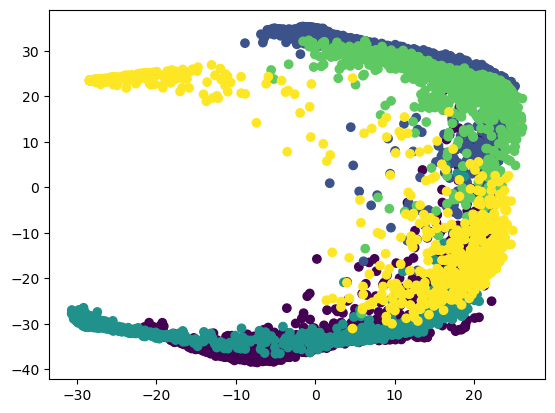

In [9]:
tree_data, tree_clusters = phate.tree.gen_dla(n_dim=n_dim, n_branch=5, branch_length=int(n_obs/5))
tree_data_pt = torch.tensor(tree_data).float().to(model.device)

model.eval()
pred = model.forward(tree_data_pt)
pred = pred.detach().cpu().numpy()
mds_operator = MDS()
pred_emb = mds_operator.fit_transform(pred)
plt.scatter(pred_emb[:, 0], pred_emb[:, 1], c=tree_clusters)

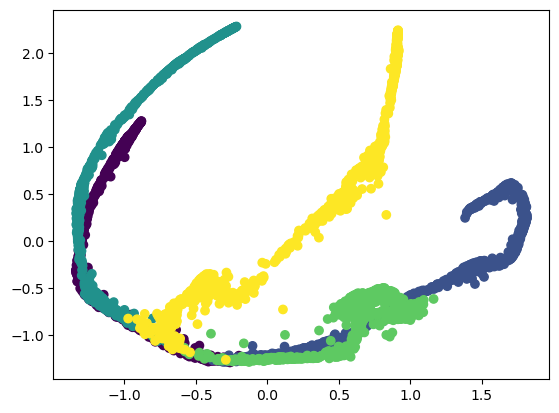

In [10]:
phate_operator = phate.PHATE(random_state=42, verbose=False, n_components=emb_dim, knn=knn)
tree_phate = phate_operator.fit_transform(tree_data)
tree_phate = scipy.stats.zscore(tree_phate) 
plt.scatter(tree_phate[:, 0], tree_phate[:, 1], c=tree_clusters)

With the distance loss / without the emb loss. 

In [43]:
kernel_type = "phate"  # "gaussian" and "phate".
loss_emb = False  # Embedding loss.
loss_dist = True # distance loss in the embedding.

In [44]:
# SEED
pl.utilities.seed.seed_everything(seed=seed)

# data loader for the training set.
train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size, knn)

# Defining the pytorch lightning model.
model = LitAutoencoder(
    input_dim=input_dim,
    encoder_layer=encoder_layer,
    activation=activation,
    lr=lr,
    kernel_type=kernel_type,
    loss_emb=loss_emb,
    loss_dist=loss_dist,
    bandwitdh=bandwitdh,
    t=t,
    scale=scale,
    knn = knn,
)

# Defining the trainer
# NOTE, we can add more things like gradient clipping, early stopping, Callbacks etc..
# NOTE logger is set to `FALSE`, change to `True` to keep tracks of the metrics.
# NOTE  `enable_checkpointing ` is set to `False`, set to `True` to keep checkpoints of the model.
trainer = Trainer(
    max_epochs=max_epochs,
    fast_dev_run=fast_dev_run,
    accelerator=accelerator,
    devices=devices,
    logger=logger,
    enable_checkpointing=False,
)

# Train the model
trainer.fit(model, train_dataloaders=train_loader)

Global seed set to 271
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 6.4 K 
---------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)
/home/mila/g/guillaume.huguet/.conda/envs/phate_fim/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 199: 100%|██████████| 10/10 [00:01<00:00,  6.30it/s, loss=533]     

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 10/10 [00:01<00:00,  6.29it/s, loss=533]


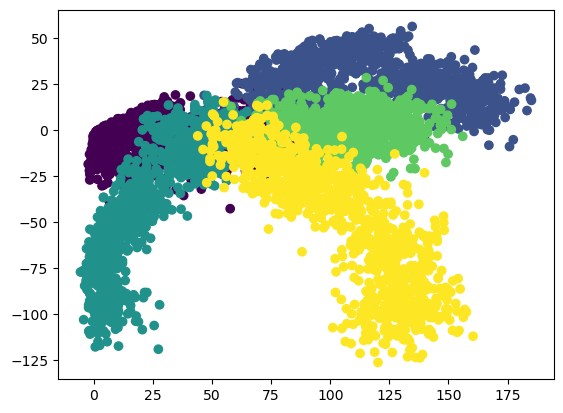

In [57]:
tree_data, tree_clusters = phate.tree.gen_dla(n_dim=n_dim, n_branch=5, branch_length=int(n_obs/5))
tree_data = torch.tensor(tree_data).float().to(model.device)

model.eval()
pred = model.forward(tree_data)
pred = pred.detach().cpu().numpy()
plt.scatter(pred[:, 0], pred[:, 1], c=tree_clusters)

With emb_loss and dist_loss

In [69]:
kernel_type = "phate"  # "gaussian" and "phate".
loss_emb = True  # Embedding loss.
loss_dist = True # distance loss in the embedding.

In [70]:
# SEED
pl.utilities.seed.seed_everything(seed=seed)

# data loader for the training set.
train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size, knn)

# Defining the pytorch lightning model.
model = LitAutoencoder(
    input_dim=input_dim,
    encoder_layer=encoder_layer,
    activation=activation,
    lr=lr,
    kernel_type=kernel_type,
    loss_emb=loss_emb,
    loss_dist=loss_dist,
    bandwitdh=bandwitdh,
    t=t,
    scale=scale,
    knn = knn,
)

# Defining the trainer
# NOTE, we can add more things like gradient clipping, early stopping, Callbacks etc..
# NOTE logger is set to `FALSE`, change to `True` to keep tracks of the metrics.
# NOTE  `enable_checkpointing ` is set to `False`, set to `True` to keep checkpoints of the model.
trainer = Trainer(
    max_epochs=max_epochs,
    fast_dev_run=fast_dev_run,
    accelerator=accelerator,
    devices=devices,
    logger=logger,
    enable_checkpointing=False,
)

# Train the model
trainer.fit(model, train_dataloaders=train_loader)

Global seed set to 320
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 6.4 K 
---------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)
/home/mila/g/guillaume.huguet/.conda/envs/phate_fim/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 199: 100%|██████████| 10/10 [00:01<00:00,  6.84it/s, loss=2.23e+03]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 10/10 [00:01<00:00,  6.83it/s, loss=2.23e+03]


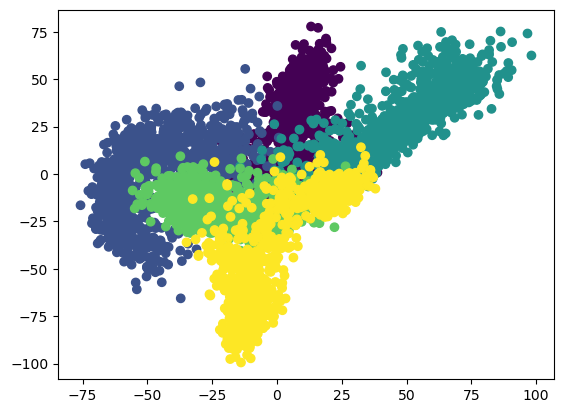

In [71]:
tree_data, tree_clusters = phate.tree.gen_dla(n_dim=n_dim, n_branch=5, branch_length=int(n_obs/5))
tree_data_pt = torch.tensor(tree_data).float().to(model.device)

model.eval()
pred = model.forward(tree_data_pt)
pred = pred.detach().cpu().numpy()
plt.scatter(pred[:, 0], pred[:, 1], c=tree_clusters)

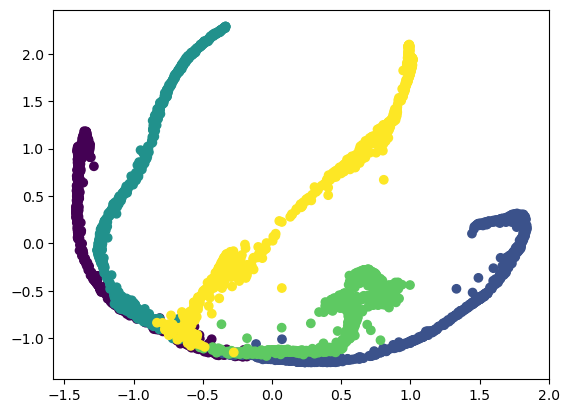

In [72]:
phate_operator = phate.PHATE(random_state=42, verbose=False, n_components=emb_dim, knn=knn)
tree_phate = phate_operator.fit_transform(tree_data)
tree_phate = scipy.stats.zscore(tree_phate) 
plt.scatter(tree_phate[:, 0], tree_phate[:, 1], c=tree_clusters)